# Music Genre Classification
The goal of this project is to design a tutorial that can help people learn how to develop a deep learning model using PyTorch. The problem statement that this tutorial will solve is: How can one classify the genre of music in an audio file using PyTorch? This tutorial will demonstrate how users can import data, design a model and examine the results. Below is an outline of the tutorial.

## Outline
1. Loading data
2. Viewing data and features in more detail
3. Creating the Data Object for Dataloading
4. Specifying Loss Function and Optimizer
5. Building the Network
6. Train the Network
7. Test the Network
8. Visualize the results

## Data Loading
### Data Details
The audio files for this project was provided by "GTZAN Dataset - Music Genre Classification" on Kaggle. The content of the genres is a collection of 100 audio files each, having a length of 30 seconds each. 

## Import Libraries

The following are libraries that are necessary for importing the data.

In [ ]:
import pandas as pd
import numpy as np

from glob import glob
import IPython
import IPython.display as ipd

import librosa
import librosa.display

import torch
import torchaudio
import matplotlib.pyplot as plt

## Download Dataset

The audio data was saved in a github repository. This repository can be cloned into your google drive.

In [ ]:
#Import data from github

!git clone https://github.com/kWeech/ENEL645A2.git
# !git pull https://github.com/kWeech/ENEL645A2.git


Cloning into 'ENEL645A2'...
remote: Enumerating objects: 2002, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 2002 (delta 0), reused 0 (delta 0), pack-reused 1997
Receiving objects: 100% (2002/2002), 1.19 GiB | 17.22 MiB/s, done.
Updating files: 100% (2001/2001), done.


This data can also be downloaded from Kaggle. Below is the code for that alternative

In [ ]:
#!mkdir ~/.kaggle #create the .kaggle folder in your root directory
#!echo '{"username":"kennethweech","key":"c8281efcda36bd6dc0a595f81d2221f3"}' > ~/.kaggle/kaggle.json #write kaggle API credentials to kaggle.json
#!chmod 600 ~/.kaggle/kaggle.json  # set permissions

#!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
#! mkdir music_dataset
#! unzip gtzan-dataset-music-genre-classification.zip -d music_dataset

## How to read the Audio Files

The glob function allows you to save search through files in a directory.

In [ ]:
audio_files = glob("/content/ENEL645A2/Data/genres_original/*/*.wav")


print("The number of audio files is: ", len(audio_files))


The number of audio files is:  1000


The IPython library can be used to play an audio file stored in Audio.

In [ ]:
ipd.Audio(audio_files[4])



*   data: raw data of the audio file (numpy array)
*   sample_rate: The sampling rate of the audio file (int)


In [ ]:
from numba.core.config import yaml
from numba.core.errors import NumbaParallelSafetyWarning
data, sample_rate = librosa.load(audio_files[4])

In [ ]:
print("The raw data for the audio file: ", data)
print("Shape of audio file: ", data.shape)
print("The sample rate is: ", sample_rate)


The raw data for the audio file:  [ 0.01882935  0.03295898  0.03451538 ... -0.07113647 -0.05267334
 -0.01193237]
Shape of audio file:  (661794,)
The sample rate is:  22050


## Visualizing the data

In [ ]:
#waveform plot function

def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)

#spectrogram plot function
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

Plotting waveform

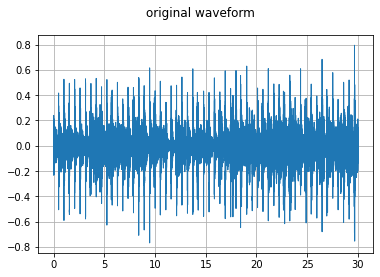

In [ ]:
data_waveform, rate_of_sample = torchaudio.load(audio_files[0])
plot_waveform(data_waveform, rate_of_sample, title="original waveform")

Plotting Mel Spectrogram

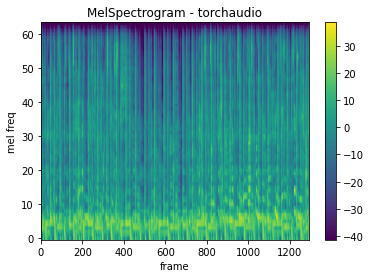

In [ ]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate = rate_of_sample,
    n_fft = 1024,
    hop_length = 512,
    n_mels = 64
)

melspec = mel_spectrogram(data_waveform)
plot_spectrogram(melspec[0].cpu().detach().numpy(), title="MelSpectrogram - torchaudio", ylabel="mel freq")

# Building a Custom Dataset

A custom dataset is a class that can be used to help preprocess and load data to the Dataloader object. Dataset objects must have a constructor, length, and getItem method. However, preprocessing steps may also be included if necessary. In the below dataset class, methods were developed for resampling the audio data if necessary, cut or pad the audio files as required, and for getting audio labels.

In [ ]:
from torch.utils.data import Dataset
import os

In [ ]:
class MusicDataset(Dataset):
  
  def __init__(self, annotations_file, audio_dir, transformation, target_sample_rate, num_samples, device):
    # Initialize the MusicDataset object with necessary parameters
    self.annotations = pd.read_csv(annotations_file) # Load the annotations CSV file as a Pandas DataFrame
    self.audio_dir = audio_dir # Directory containing the audio files
    self.device = device # Device (CPU/GPU) on which the data will be loaded
    self.transformation = transformation.to(self.device) # Transformation to be applied to the audio signal
    self.target_sample_rate = target_sample_rate # Target sampling rate for the audio signal
    self.num_samples = num_samples # Number of samples to be taken from the audio signal
  
  def __len__(self):
    # Return the number of samples in the dataset
    return len(self.annotations)

  def __getitem__(self, index):
    # Get the audio signal and its label for the given index
    audio_sample_path = self._get_audio_sample_path(index) # Get the path to the audio sample file
    label = self._get_audio_sample_label(index) # Get the label for the audio sample
    signal, sr = torchaudio.load(audio_sample_path) # Load the audio signal and its sampling rate
    signal = signal.to(self.device) # Move the signal to the given device
    signal = signal[:,:660000] # Cut the signal to be the first 660000 samples
    signal = self.transformation(signal) # Apply the transformation to the audio signal
    return signal, label


  def _resample_if_necessary(self, signal, sr):
    # Resample the signal if its sampling rate is different from the target sampling rate
    if sr != self.target_sample_rate:
        resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate) # Create a resampler object
        signal = resampler(signal) # Resample the signal
    return signal

  def _get_audio_sample_path(self, index):
    # Get the path to the audio sample file for the given index
    fold = f"{self.annotations.iloc[index, 59]}" # Get the folder name containing the audio file
    path = os.path.join(self.audio_dir,fold, self.annotations.iloc[
        index, 0]) # Combine the folder name, audio file name, and directory path to get the full path to the audio file
    return path

  def _cut_if_necessary(self, signal):
        # Cut the signal if its length is greater than the specified number of samples
    if signal.shape[1] > self.num_samples:
        signal = signal[:, :self.num_samples]
    return signal

  def _right_pad_if_necessary(self, signal):
    # Pad the signal with zeros if its length is less than the specified number of samples
    length_signal = signal.shape[1]
    if length_signal < self.num_samples:
        num_missing_samples = self.num_samples - length_signal
        last_dim_padding = (0, num_missing_samples) # Padding tuple for the last dimension of the signal tensor
        signal = torch.nn.functional.pad(signal, last_dim_padding) # Pad the signal with zeros
    return signal

  def _mix_down_if_necessary(self, signal):
    if signal.shape[0] > 1: # Check if the signal has more than one channel (shape[0] is the number of channels)
        signal = torch.mean(signal, dim = 0, keepdim = True) # Average the signal across all channels to mix it down to mono
    return signal


  def _get_audio_sample_label(self,index):
    # Get the label for the audio sample for the given index
    return self.annotations.iloc[index, 60] # Return the label from the annotations DataFrame


  def _getUniqueLabels(self):
    # Get the unique classes (folders) from the annotations and assign them integer labels
    classes = np.unique(self.annotations.iloc[:, 59]).flatten()
    labels_int = np.zeros(len(self.annotations.iloc[:, 59]), dtype = np.int64)
    for ii,jj in enumerate(classes):
         labels_int[self.annotations.iloc[:, 59] == jj] = ii
    self.annotations["formattedLabel"] = labels_int; # Add a new column to the annotations DataFrame with the integer labels
    print(self.annotations.shape[0]) # Print the number of rows in the annotations DataFrame (i.e., the number of samples in the dataset)

In [ ]:
# Define the file paths and parameters for the dataset
ANNOTATIONS_FILE = "/content/ENEL645A2/Data/features_30_sec.csv"
AUDIO_DIR = "/content/ENEL645A2/Data/genres_original"
SAMPLE_RATE = 22050
NUM_SAMPLES = 1000

# Check if a GPU is available, otherwise use CPU
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Using device {device}")

# If you have issues with GPU, you can force CPU
#device = "cpu"

# Create a MelSpectrogram transform to convert audio to MelSpectrogram
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate = SAMPLE_RATE,
    n_fft = 1024,
    hop_length = 512,
    n_mels = 64
)

# Create a MusicDataset object using the defined parameters
md = MusicDataset(ANNOTATIONS_FILE,
                  AUDIO_DIR, 
                  mel_spectrogram, 
                  SAMPLE_RATE,
                  NUM_SAMPLES,
                  device)

print(f"There are {len(md)} samples in the dataset.")

# Get unique labels for the dataset and print the number of samples
md._getUniqueLabels()

# Get the signal and label for the first sample in the dataset and print the signal for the third sample
signal, label = md[1]
print(md[3])

Using device cuda
There are 1000 samples in the dataset.
1000
(tensor([[[4.2096e+02, 8.6064e+01, 8.5212e+01,  ..., 1.6491e-01,
          4.3301e-01, 1.1270e+01],
         [6.4105e+02, 2.3573e+03, 2.3108e+03,  ..., 4.4749e+01,
          1.7371e+01, 9.2897e+00],
         [1.2342e+03, 1.2130e+03, 9.9125e+02,  ..., 4.3140e+01,
          2.2703e+01, 1.1163e+01],
         ...,
         [3.9097e-03, 1.6319e-04, 1.1346e-04,  ..., 5.8817e-05,
          5.0913e-05, 1.2070e-04],
         [3.6696e-03, 8.8342e-06, 4.0702e-06,  ..., 3.3592e-06,
          2.1690e-06, 9.8354e-05],
         [3.5873e-03, 7.4231e-07, 7.2199e-07,  ..., 7.0537e-07,
          7.9032e-07, 8.1620e-05]]], device='cuda:0'), 0)


Testing that each audio file contains data

In [ ]:

audio_files_Test = []
for i in range(1000):
  try:
    md[i]
    audio_files_Test =  audio_files_Test + [True]
  except:
    print(i)
    audio_files_Test =  audio_files_Test + [False]

# print(audio_files_Test.unique)


In [ ]:
import collections
print(collections.Counter(audio_files_Test))

Counter({True: 1000})


# Creating the Neural Network

This code creates the neural network layers including 4 convoluational layers that include a ReLu activation and max pooling then flattens into a fully connected layer. The network ends with a softmax activation to complete final predictions. There are many possible model setups and it is possible to create a model that would likely be more accurate for this dataset. However, for the sake of this tutorial, this model structure helps to see how each type of layer is created and connected.

In [ ]:
#Import libraries
from torch import nn
from torchsummary import summary

#Create CNN Class
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    # 4 conv layers --> flatten --> linear --> softmax

    #Build network layers
    #Create first convultional layer
    self.conv1 = nn.Sequential(
        #Convalutional --> ReLu --> Max Pooling
        nn.Conv2d(
            #Number of input channels
            in_channels=1,
            #Num of filters
            out_channels=16,
            #apply kernel size
            kernel_size=3,
            #apply stride 
            stride=1,
            #apply padding size
            padding=2
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv2 = nn.Sequential(
        #Convalutional --> ReLu --> Max Pooling
        nn.Conv2d(
            #Number of input channels
            in_channels=16,
            #Num of filters
            out_channels=32,
            #apply kernel size
            kernel_size=3,
            #apply stride 
            stride=1,
            #apply padding size
            padding=2
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv3 = nn.Sequential(
        #Convolutional --> ReLu --> Max Pooling
        nn.Conv2d(
            #Number of input channels
            in_channels=32,
            #Num of filters
            out_channels=64,
            #apply kernel size
            kernel_size=3,
            #apply stride 
            stride=1,
            #apply padding size
            padding=2
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv4 = nn.Sequential(
        #Convalutional --> ReLu --> Max Pooling
        nn.Conv2d(
            #Number of input channels
            in_channels=64,
            #Num of filters
            out_channels=128,
            #apply kernel size
            kernel_size=3,
            #apply stride 
            stride=1,
            #apply padding size
            padding=2
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    
    #Define flatten layer    
    self.flatten = nn.Flatten()

    #Define dense layer: 
    #128 * 2 * 5 = shape of data
    #10 = number of possible genres (outputs)
    self.linear = nn.Linear(52480, 10)

    #Define final softmax activation
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input_data):
    #Send input data through all layers
    x = self.conv1(input_data)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.flatten(x)
    logits = self.linear(x)
    predictions = self.softmax(logits)

    return predictions

In [ ]:
#Summarize model information

cnn = CNN()
#1 = num of channels
#64 = frequency axis
#44 = time axis
# summary(cnn.cuda(), (1, 64, 44))

# Training the Model

This section includes creating all necessary functions for training the CNN model. Constants of batch size, epochs and learning rate are set and can be tuned based on model accuracy.

In [ ]:
#Preparing to train the data
#import DataLoader
from torch.utils.data import DataLoader

#Initialize training constants 
BATCH_SIZE = 15
EPOCHS = 10
LEARNING_RATE = 0.001

#Set training device to GPU
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
print(f"Using device {device}")

#Define data_loader function
def create_data_loader(train_data, batch_size):
  train_dataloader = DataLoader(train_data, batch_size=batch_size)
  return train_dataloader

#Create a function for training a single epoch
def train_single_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
  total_loss = 0
  correct_predictions = 0
  total_predictions = 0
  for input, target in data_loader:
    #Make sure input and target shapes are correctly shaped to your data
    # print("INPUT SHAPE:", input.shape)
    input = input.to(device)
    target = torch.tensor(target).to(device)
    # print("TARGET SHAPE:", target.shape)

    #Calculate loss each iteration
    prediction = model(input)
    loss = loss_fn(prediction, target)

    #Calculate accuracy
    _, predicted_labels = torch.max(prediction.data, 1)
    total_predictions += target.size(0)
    correct_predictions += (predicted_labels == target).sum().item()

    #Backpropogate error and update weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  scheduler.step()

  #Print loss for each iteration
  print(f"Accuracy : {correct_predictions / total_predictions}")
  print(f"loss : {loss.item()}")

#Create train function that trains entire model over each epoch
def train(model, data_loader, loss_fn, optimizer, device, epochs, scheduler):
  for i in range(epochs):
    print(f"Epoch #{i+1}")
    train_single_epoch(model, data_loader, loss_fn, optimizer, device, scheduler)
  print("Model Trained")



Using device cuda


In [ ]:
#Training the data
#Create dataloader
train_dataloader = create_data_loader(md, BATCH_SIZE)

#Construct neural network model and assign to device
cnn = CNN().to(device)
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=52480, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [ ]:
#Define loss function
loss_fn = nn.CrossEntropyLoss()

#Define optimizer
#Tried two different optimizers and found better success with SGD over Adam

# 1 - Adam Optimizer
#optimizer = torch.optim.Adam(cnn.parameters(), lr = LEARNING_RATE)

# 2 - SGD
optimizer = torch.optim.SGD(cnn.parameters(), lr = LEARNING_RATE, momentum=0.9)

#Set scheduler
scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer=optimizer,
        step_size=1,
        gamma=0.2,
    )

# Training Results

As seen from the below accuracy and loss scores - there seems to be some error with the training. This could be related to low volume of data samples (only used 1000). Since CNN models need to learn local relations between the data it will likely perform better with more data. For the sake of this tutorial, we proceeded with this model and completed predictions as it is still a good representation of how models can complete predictions.

In [ ]:
#Train model
train(cnn, train_dataloader, loss_fn, optimizer, device, EPOCHS, scheduler)

#Store the model
torch.save(cnn.state_dict(), "cnn.pth")


Epoch #1


<ipython-input-26-e018cb72fd41>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target).to(device)


Accuracy : 0.1
loss : 2.4611504077911377
Epoch #2
Accuracy : 0.1
loss : 2.4611504077911377
Epoch #3
Accuracy : 0.1
loss : 2.4611504077911377
Epoch #4
Accuracy : 0.1
loss : 2.4611504077911377
Epoch #5
Accuracy : 0.1
loss : 2.4611504077911377
Epoch #6
Accuracy : 0.1
loss : 2.4611504077911377
Epoch #7
Accuracy : 0.1
loss : 2.4611504077911377
Epoch #8
Accuracy : 0.1
loss : 2.4611504077911377
Epoch #9
Accuracy : 0.1
loss : 2.4611504077911377
Epoch #10
Accuracy : 0.1
loss : 2.4611504077911377
Model Trained


In [ ]:
#Load back the model
cnn = CNN()
state_dict = torch.load("cnn.pth")
cnn.load_state_dict(state_dict)

<All keys matched successfully>

### Creating the predict function to get the accuracy of the test and train data sets.

This code defines a function called "predict" that takes as input a PyTorch model, an input tensor, a target label, and a class mapping list. The function performs inference using the model and the input tensor and returns the predicted and expected class labels (based on the class mapping list) as output.

The code then uses this "predict" function to make predictions on a sample of the Music dataset. It loops over the first 1000 samples of the dataset, gets the input and target values for each sample, and calls the "predict" function to make a prediction. If the predicted label matches the expected label, the number of correct predictions is incremented.

Finally, the code prints out the number of correct predictions and the overall accuracy of the model on the sample, which is calculated as the percentage of correct predictions out of the total number of predictions (1000).



In [ ]:
# Define a list that maps each genre to a number
class_mapping = [
    "blues",
    "classical",
    "country",
    "disco",
    "hiphop",
    "jazz",
    "metal",
    "pop",
    "reggae",
    "rock"
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Set the model to evaluation mode
def predict(model, input, target, class_mapping, device):
  # Set the model to evaluation mode
    model.eval() 

    # Turn off gradient computation
    with torch.no_grad():
        # Make a prediction on the input using the model
        input = input.to(device)
        model = model.to(device)
        predictions = model(input)
        # Find the index of the maximum score in the predictions
        predicted_index = predictions[0].argmax(0)
        # Get the predicted and expected genres using the class mapping
        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]
    # Return the predicted and expected genres
    return predicted, expected

# Get a sample from the Music dataset for inference
# Getting the first sample in the dataset and get the input and target/expected output


correct_predictions = 0

# Loop through the first 1000 samples in the dataset
for i in range(1000):

  # Get the input and target for the current sample
  input, target = md[i][0], md[i][1]

  # Add a batch dimension to the input tensor
  input.unsqueeze_(0)

  # Make a prediction using the neural network
  predicted, expected = predict(cnn, input, target, class_mapping, device)

  # Check if the predicted genre matches the expected genre
  if(predicted == expected):
    correct_predictions +=1

# Print the accuracy of the predictions
print("Predictions Complete!")
print(f'Accuracy = {(correct_predictions/1000)*100}%')


Predictions Complete!
Accuracy = 10.0%
